# Theory

#### Derive the least squares regression solution with a quadratic regulariser, for which the total error function is
\begin{equation}
\frac{1}{2}\sum_{i=1}^n[t_i - \textbf{w}^\textrm{T}\textbf{x}_i]^2 + \frac{\lambda}{2}\textbf{w}^\textrm{T}\textbf{w} = \frac{1}{2}(\textbf{t} - \textbf{X}\textbf{w})^\textrm{T}(\textbf{t} - \textbf{X}\textbf{w}) + \frac{\lambda}{2}\textbf{w}^\textrm{T}\textbf{w}
\end{equation}

\begin{equation}
\frac{\delta L}{\delta w} = \frac{1}{2}[2(-\textbf{X})^\textrm{T}(\textbf{t} - \textbf{X}\textbf{w})] + \lambda\textbf{w} = \textbf{X}^\textrm{T}\textbf{X}\textbf{w} - \textbf{X}^\textrm{T}\textbf{t} + \lambda\textbf{I}\textbf{w}
\end{equation}
\begin{equation}
\text{Set it to 0: }\;(\textbf{X}^\textrm{T}\textbf{X} + \lambda\textbf{I})\textbf{w} = \textbf{X}^\textrm{T}\textbf{t}\\
\implies \textbf{w} = (\lambda\textbf{I} + \textbf{X}^\textrm{T}\textbf{X})^{-1}\textbf{X}^\textrm{T}\textbf{t}
\end{equation}

# Implementation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import add_dummy_feature
import sys

In [179]:
pd.set_option("display.precision", 8)

In [90]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [91]:
import cross_validation.cv as cv
import linear_model.logistic_regression as lr
import optimise.gradient_descent as gd

#### Download the full spambase dataset

In [3]:
spam = pd.read_csv('../data/spambase.csv')

In [93]:
spam.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


In [94]:
spam.shape

(4601, 58)

In [95]:
x = spam[spam.columns[:-1]]
y = spam['class']

## Binary logistic regression with quadratic regulariser

#### Implementation
LogisticRegression class that minimizes the regularized cost function (with L2 regularization) using gradient descent implemented in separate folder

#### Data preparation
Partition into training/validation sets, and standardise

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

In [97]:
sc_x = StandardScaler()
x_train_std = sc_x.fit_transform(x_train)
x_test_std = sc_x.transform(x_test)

In [98]:
x_train_std = add_dummy_feature(x_train_std)
x_test_std = add_dummy_feature(x_test_std)

### Using regularisation strength, lambda = 1

#### Model training

_Model implemented from scratch_

In [99]:
classifier = lr.LogisticRegression(penalty='l2', max_iter=np.inf, fit_intercept=False)

In [100]:
classifier.fit(x_train_std, y_train, keep_intermediate_betas=True)

_Scikit-learn model for comparison_

In [101]:
classifier_skl = LogisticRegression(fit_intercept=False, tol=1e-6)
classifier_skl.fit(x_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

#### Comparison of fitted parameters

In [102]:
classifier.beta

array([-2.05279698e+00, -1.80883811e-01, -1.64615126e-01,  8.93285385e-02,
        6.91759687e-01,  3.71504518e-01,  1.74877641e-01,  8.15655795e-01,
        1.81438935e-01,  1.16368503e-01,  6.58693820e-02,  2.34892890e-02,
       -1.46703423e-01, -9.33148764e-03,  2.75863847e-02,  6.31418312e-01,
        7.23241284e-01,  5.18068316e-01,  4.71142203e-02,  1.92747401e-01,
        3.07407068e-01,  3.19337702e-01,  3.72015226e-01,  9.48050140e-01,
        3.40268890e-01, -2.12548510e+00, -7.58313418e-01, -3.34577866e+00,
        2.87347335e-01, -8.81913263e-01, -1.84462778e-01, -1.60671570e-01,
       -9.63095979e-02, -4.25793338e-01, -1.78937530e-01, -6.59782372e-01,
        2.39817160e-01, -1.19809032e-03, -1.25712601e-01, -3.63338354e-01,
       -1.55397347e-01, -1.32854672e+00, -1.29358135e+00, -2.81123579e-01,
       -7.52973296e-01, -6.97454020e-01, -1.20851861e+00, -2.65814215e-01,
       -9.03119209e-01, -3.39364418e-01, -2.36309113e-02, -8.17980793e-02,
        5.21780486e-01,  

In [103]:
print('sklearn beta:', classifier_skl.coef_)

sklearn beta: [[-2.16583919e+00 -1.81554763e-01 -1.64862777e-01  8.89219091e-02
   7.25617314e-01  3.70721697e-01  1.79915700e-01  8.12025343e-01
   1.79579214e-01  1.17321207e-01  6.59785585e-02  2.28691849e-02
  -1.45992021e-01 -8.42242264e-03  2.93913814e-02  6.26157968e-01
   7.44074046e-01  5.17932338e-01  4.58832012e-02  1.91024537e-01
   3.10251511e-01  3.19965880e-01  3.61580567e-01  9.40566562e-01
   3.37324306e-01 -2.16449615e+00 -7.53753611e-01 -3.68314467e+00
   2.89045937e-01 -9.11361397e-01 -1.83807323e-01 -1.33107498e-01
  -7.71962994e-02 -4.23134993e-01 -1.72412281e-01 -6.60815008e-01
   2.42921356e-01 -5.37640868e-04 -1.28482571e-01 -3.67980899e-01
  -1.56633566e-01 -1.61541117e+00 -1.31938059e+00 -2.81379753e-01
  -7.57899685e-01 -6.93574749e-01 -1.20869837e+00 -2.67807302e-01
  -9.21855249e-01 -3.38045657e-01 -2.36711350e-02 -7.88265590e-02
   5.17306673e-01  1.28043817e+00  9.85221646e-01 -2.25848747e-01
   9.36756655e-01  4.59721155e-01]]


In [114]:
normed_diff = (classifier.beta - classifier_skl.coef_) / classifier_skl.coef_

In [115]:
print('normalised difference:', normed_diff)

normalised difference: [[-5.21932610e-02 -3.69559350e-03 -1.50216496e-03  4.57288222e-03
  -4.66604443e-02  2.11161409e-03 -2.80023292e-02  4.47086064e-03
   1.03559908e-02 -8.12047422e-03 -1.65472634e-03  2.71152682e-02
   4.87287978e-03  1.07933910e-01 -6.14124489e-02  8.40098564e-03
  -2.79982379e-02  2.62540016e-04  2.68294063e-02  9.01907409e-03
  -9.16818297e-03 -1.96326656e-03  2.88584603e-02  7.95645820e-03
   8.72923717e-03 -1.80231552e-02  6.04946698e-03 -9.15972729e-02
  -5.87657921e-03 -3.23122457e-02  3.56598944e-03  2.07081291e-01
   2.47593455e-01  6.28249974e-03  3.78467766e-02 -1.56266893e-03
  -1.27786060e-02  1.22842122e+00 -2.15591096e-02 -1.26162672e-02
  -7.89242500e-03 -1.77579834e-01 -1.95540558e-02 -9.10417627e-04
  -6.50005449e-03  5.59315573e-03 -1.48720936e-04 -7.44224386e-03
  -2.03242756e-02  3.90113289e-03 -1.69927270e-03  3.76969421e-02
   8.64827821e-03  4.45792356e-03 -6.56105712e-02  2.74867876e-02
   2.20109435e-02 -2.48186152e-02]]


In [119]:
print('max. absolute normalised difference:', np.abs(normed_diff).max())

max. absolute normalised difference: 1.2284212233026635


In [116]:
print('average absolute normalised difference:', np.abs(normed_diff).mean())

average absolute normalised difference: 0.049470740583886175


In [118]:
print('median absolute normalised difference:', np.median(np.abs(normed_diff)))

median absolute normalised difference: 0.009093628531570334


*Remarks*: The normalised differences are not large in most cases, though the maximum is ~123%. Generally, the estimates are reassuringly similar, with an average absolute difference of 4.95%, and median absolute difference of 0.91%.

#### Prediction error rates on training and test sets

_Model implemented from scratch_

In [120]:
(classifier.predict(x_train_std) != y_train).astype(int).mean()

0.06782608695652174

In [121]:
(classifier.predict(x_test_std) != y_test).astype(int).mean()

0.07211120764552563

_Scikit-learn model for comparison_

In [122]:
(classifier_skl.predict(x_train_std) != y_train).astype(int).mean()

0.0672463768115942

In [123]:
(classifier_skl.predict(x_test_std) != y_test).astype(int).mean()

0.07211120764552563

#### Illustrate convergence (on from-scratch model only)
Plot loss function value (negative log-likelihood + penalty) on the training/validation sets at each parameter update

1. Using training set

In [124]:
training_losses = classifier.loss(x_train_std, y_train, use_intermediate_betas=True)

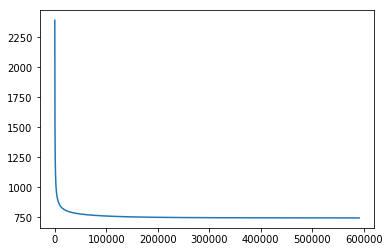

In [125]:
plt.plot(range(len(classifier.betas)), training_losses)

In [126]:
training_losses.shape

(591306,)

In [134]:
training_losses[training_losses < 900].shape

(585876,)

In [135]:
training_losses[training_losses < 800].shape

(565594,)

In [136]:
training_losses[training_losses < 750].shape

(386395,)

1. Using test set

In [130]:
test_losses = classifier.loss(x_test_std, y_test, use_intermediate_betas=True)

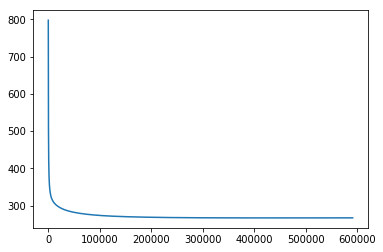

In [131]:
plt.plot(range(len(classifier.betas)), test_losses)

In [137]:
test_losses[test_losses < 300].shape

(574477,)

**Remarks**: In both training and test sets, the loss function value declines very rapidly to a near-optimal value within a small fraction (less than 5%) of the number of iterations taken to reach convergence, then decreases very gradually over the remaining iterations

#### k-fold cross-validation

_Model implemented from scratch_

In [ ]:
predictions, errors, cv_error = cv.k_fold_cv(x, y, 5, classifier)

In [142]:
cv_error

0.000434546570363027

_Scikit-learn model for comparison_

In [ ]:
skl_predictions, skl_errors, skl_cv_error = cv.k_fold_cv(x, y, 5, classifier_skl)

In [144]:
skl_cv_error

0.0002173913043478261

### Regularisation strength selection with k-fold cross-validation

In [145]:
# Use k = 5 because fitting takes a while (for from-scratch model), and k=5 already necessitates 5 * 20 = 100 fittings
k = 5
# Omit 0 because I don't have yet more time to sink into getting it to work with an off-the-shelf library:
# sklearn's saga solver is too slow, and statsmodel's API is opaque and may be incompatible with my CV function
lambdas = np.arange(0.5, 10.5, 0.5)

_Model implemented from scratch_

In [ ]:
# Note: takes several minutes
cv_errors = pd.Series(0.0, index=lambdas)
for strength in lambdas:
    cv_classifier = lr.LogisticRegression(penalty='l2', reg_strength=strength, max_iter=np.inf, fit_intercept=False)
    cv_errors[strength] = cv.k_fold_cv(x, y, k, cv_classifier)[2]

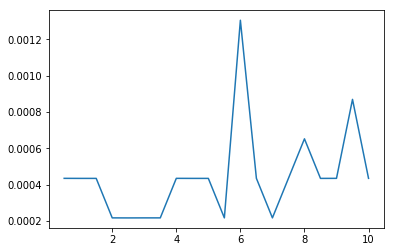

In [175]:
plt.plot(lambdas, cv_errors)

In [180]:
cv_errors

0.5     0.00043478
1.0     0.00043455
1.5     0.00043455
2.0     0.00021739
2.5     0.00021716
3.0     0.00021739
3.5     0.00021739
4.0     0.00043478
4.5     0.00043455
5.0     0.00043455
5.5     0.00021739
6.0     0.00130435
6.5     0.00043478
7.0     0.00021739
7.5     0.00043478
8.0     0.00065217
8.5     0.00043455
9.0     0.00043478
9.5     0.00086909
10.0    0.00043478
dtype: float64

In [203]:
min_cv_errors = cv_errors.min()
cv_errors_min_lambdas = cv_errors[cv_errors == min_cv_errors].index
best_lambda = cv_errors_min_lambdas[-1]

In [150]:
classifier_best_lambda = lr.LogisticRegression(penalty='l2', max_iter=np.inf, fit_intercept=False, reg_strength=best_lambda)
classifier_best_lambda.fit(x_train_std, y_train)

_Scikit-learn model for comparison_

In [193]:
cv_errors_skl = pd.Series(0.0, index=lambdas)

In [194]:
for strength in lambdas:
    print(strength)
    cv_classifier_skl = LogisticRegression(fit_intercept=False, tol=1e-6, C=1.0/strength)
    cv_errors_skl[strength] = cv.k_fold_cv(x, y, k, cv_classifier_skl, cv_verbose=True)[2]

0.5
fold  1
fold  2
fold  3
fold  4
fold  5
1.0
fold  1
fold  2
fold  3
fold  4
fold  5
1.5
fold  1
fold  2
fold  3
fold  4
fold  5
2.0
fold  1
fold  2
fold  3
fold  4
fold  5
2.5
fold  1
fold  2
fold  3
fold  4
fold  5
3.0
fold  1
fold  2
fold  3
fold  4
fold  5
3.5
fold  1
fold  2
fold  3
fold  4
fold  5
4.0
fold  1
fold  2
fold  3
fold  4
fold  5
4.5
fold  1
fold  2
fold  3
fold  4
fold  5
5.0
fold  1
fold  2
fold  3
fold  4
fold  5
5.5
fold  1
fold  2
fold  3
fold  4
fold  5
6.0
fold  1
fold  2
fold  3
fold  4
fold  5
6.5
fold  1
fold  2
fold  3
fold  4
fold  5
7.0
fold  1
fold  2
fold  3
fold  4
fold  5
7.5
fold  1
fold  2
fold  3
fold  4
fold  5
8.0
fold  1
fold  2
fold  3
fold  4
fold  5
8.5
fold  1
fold  2
fold  3
fold  4
fold  5
9.0
fold  1
fold  2
fold  3
fold  4
fold  5
9.5
fold  1
fold  2
fold  3
fold  4
fold  5
10.0
fold  1
fold  2
fold  3
fold  4
fold  5


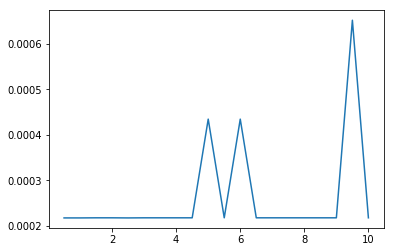

In [195]:
plt.plot(lambdas, cv_errors_skl)

In [196]:
cv_errors_skl

0.5     0.00021716
1.0     0.00021716
1.5     0.00021739
2.0     0.00021739
2.5     0.00021716
3.0     0.00021739
3.5     0.00021739
4.0     0.00021739
4.5     0.00021739
5.0     0.00043455
5.5     0.00021739
6.0     0.00043455
6.5     0.00021739
7.0     0.00021739
7.5     0.00021739
8.0     0.00021739
8.5     0.00021739
9.0     0.00021739
9.5     0.00065217
10.0    0.00021739
dtype: float64

In [207]:
min_cv_errors_skl = cv_errors_skl.min()
cv_errors_min_lambdas_skl = cv_errors_skl[cv_errors_skl == min_cv_errors_skl].index
best_lambda_skl = cv_errors_min_lambdas_skl[-1]

In [208]:
best_lambda_model_skl = LogisticRegression(fit_intercept=False, tol=1e-6, C=best_lambda_skl)
best_lambda_model_skl.fit(x_train_std, y_train)

LogisticRegression(C=2.5, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

In [209]:
print('Best lambda for from-scratch model = %f, best lambda for sklearn model = %f' % (best_lambda, best_lambda_skl))

Best lambda for from-scratch model = 2.500000, best lambda for sklearn model = 2.500000


*Remarks*: CV error both vary unevenly with lambda in the two implementations, with spikes and troughs throughout the range. They differed in that the sklearn models had uniformly low CV error with 3 isolated spikes, and lower values overall. Ultimately, however, they coincided in optimal lambda value, 2.5, with the only lambda giving optimal CV error in from-scratch models being the last such lambda in sklearn models.

#### Comparison of fitted parameters

In [210]:
normed_diff = (classifier_best_lambda.beta - best_lambda_model_skl.coef_) / best_lambda_model_skl.coef_

In [211]:
print('normalised difference:', normed_diff)

normalised difference: [[-0.41004959 -0.0866814  -0.07470117  0.08651487 -0.45442294  0.00764061
  -0.182302    0.02299066  0.14717541  0.00631331 -0.0148042   0.27486886
   0.03125935  0.0659789  -0.38537508 -0.06522156 -0.19094063 -0.05549444
   0.64482734  0.07433717 -0.14486787 -0.00673743  0.15119345  0.02296688
   0.10155582 -0.26240951 -0.03817651 -0.55970948 -0.17185167 -0.35096955
   0.06184615  1.85259112  4.424763    0.01787412  0.21843542 -0.20741757
  -0.20646553 -3.7381788  -0.16279612 -0.1228519  -0.11081866 -0.63335673
  -0.29194889 -0.10721406 -0.20957741 -0.0495216  -0.14177868 -0.1440774
  -0.30807766 -0.02567524 -0.02458947  0.34583321  0.08491924 -0.04571484
  -0.39872307 -0.27868277 -0.13842971 -0.11954574]]


In [212]:
print('max. absolute normalised difference:', np.abs(normed_diff).max())

max. absolute normalised difference: 4.424762997420581


In [213]:
print('average absolute normalised difference:', np.abs(normed_diff).mean())

average absolute normalised difference: 0.3373110653198297


In [214]:
print('median absolute normalised difference:', np.median(np.abs(normed_diff)))

median absolute normalised difference: 0.14292804048262223


*Remarks*: The normalised parameter differences with the lambda selected by k-fold CV seem somewhat larger than those estimated on the training set with lambda=1, along with a larger maximum of over 442%. This translates into a somewhat higher average, of 33.73%, versus below 5%.

#### Prediction error rates on training and test sets

_Model implemented from scratch_

In [215]:
(classifier_best_lambda.predict(x_train_std) != y_train).astype(int).mean()

0.06869565217391305

In [216]:
(classifier_best_lambda.predict(x_test_std) != y_test).astype(int).mean()

0.07471763683753258

_Scikit-learn model for comparison_

In [217]:
(best_lambda_model_skl.predict(x_train_std) != y_train).astype(int).mean()

0.06753623188405797

In [218]:
(best_lambda_model_skl.predict(x_test_std) != y_test).astype(int).mean()

0.07124239791485665